# Диффузионные модели
Данный нотбук является отчётом по практической части задания для поступления на кафедру ММП.
Практическая задача заключалась в реализации алгоритма диффузионой модели. В качестве обучающего датасета был выбран MNIST.
Основная теоретическая часть содержится в отчёте в формата ".pdf".

Стандартный импорт библиотек:

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from diffusers import UNet2DModel

Теперь перечислим наши гиперпараметры:

In [ ]:
input_size = 32 #размер изображения
channels = 1 #количество каналов
numbers_sample = 16 #количество примеров генерации
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #выбор устройства для работы
epochs = 10 #число эпох обучения
T = 1000 #число шагов зашумления
batch_size = 128 #размер батча
betas = torch.linspace(1e-4, 0.02, T, device=device) #параметры дисперсий диффузионной модели

Напишем функцию подгрузки нашего датасета. При этом, не забываем нормализовывать данные для стабильности обучения. И добавим к картинкам "рамку" из нулей, чтобы увеличить их размерность до числа 2 в степени (нужно для корректной работы модели, предсказывающей добавленный шум):

In [ ]:
def load_data():
	transform = transforms.Compose([
		transforms.ToTensor(),
    transforms.Lambda(lambda x: nn.functional.pad(x, (2, 2, 2, 2), value=0)),
		transforms.Normalize((0.5), (0.5))
	])

	train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	return train_loader

Теперь объявим класс - наша диффузионная модель. Он содержит в себе дополнительно 3 функции: прямой процесс, обратный процесс (генерация $x_{t-1}$ из $x_t$) и процесс генерации, в котором мы итерационно вызываем предыдущую функцию и, тем самым, генерируем $x_0$:

In [ ]:
class Diffusion:
    def __init__(self, model):
        self.model = model
        self.T = T
        self.betas = betas
        self.alphas = 1. - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim = 0)

    def forward_process(self, x0, t):
        noise = torch.randn_like(x0) #генерация шума
        alphas_bar_t = self.alphas_bar[t][:, None, None, None]
        return torch.sqrt(alphas_bar_t) * x0 + torch.sqrt(1. - alphas_bar_t) * noise, noise #нахождение изображения на шаге t и его возврат вместе с шумом

    def reverse_process(self, xt, t):
        t = torch.full((xt.shape[0],), t, device=device, dtype=torch.long) #преобразование t в тензор
        betas_t = self.betas[t][:, None, None, None]
        alphas_t = self.alphas[t][:, None, None, None]
        alphas_bar_t = self.alphas_bar[t][:, None, None, None]
        pred_noise = self.model(xt, t).sample #предсказание шума
        new_x = (xt - betas_t * pred_noise / torch.sqrt(1. - alphas_bar_t)) / torch.sqrt(alphas_t) #нахождение изображения с предыдущего шага по формуле
        noise = torch.randn_like(xt) if t[0] != 0 else torch.zeros_like(xt) #добавление шума в случае, если не последний этап
        return new_x + torch.sqrt(betas_t) * noise

    def generate(self, shape, device):
        xt = torch.randn(shape, device=device) #генерация шума
        for t in range(self.T - 1, -1, -1): #цикл восстановления изображения
            xt = self.reverse_process(xt, t)
        return xt

Теперь напишем функцию обучения модели:

In [ ]:
def train(model, diffusion, optimizer):
    data = load_data()
    loss_func = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        sum_loss = 0.0
        for x0, _ in data:
            optimizer.zero_grad()
            x0 = x0.to(device)
            t = torch.randint(0, T, (x0.shape[0],), device=device).long()
            xt, noise = diffusion.forward_process(x0, t)
            pred_noise = model(xt, t).sample
            loss = loss_func(noise, pred_noise)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        print(f"Epoch: {epoch + 1}, loss: {sum_loss / len(data):.4f}")

Осталось реализовать функцию для визуализации сгенерированных картинок:

In [ ]:
def image_generation(model, diffusion):
    model.eval()
    with torch.no_grad():
        new_img = diffusion.generate((numbers_sample, channels, input_size, input_size), device)
        new_img = (new_img * 0.5 + 0.5).cpu()
        out_img = make_grid(new_img, nrow=4, padding=2)
        plt.imshow(out_img.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

Ну всё! Остаётся только запустить процесс обучения. Тут мы будем пользоваться функцией UNet2DModel из библиотеки diffusers, которая инициализирует UNet - модель, которая и будет предсказывать шум:

Start train


100%|██████████| 9.91M/9.91M [00:10<00:00, 905kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.11MB/s]


Epoch: 1, loss: 0.0421
Epoch: 2, loss: 0.0231
Epoch: 3, loss: 0.0216
Epoch: 4, loss: 0.0202
Epoch: 5, loss: 0.0194
Epoch: 6, loss: 0.0188
Epoch: 7, loss: 0.0187
Epoch: 8, loss: 0.0183
Epoch: 9, loss: 0.0180
Epoch: 10, loss: 0.0180
End train
Image generation


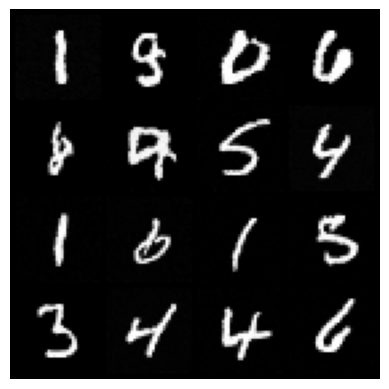

In [ ]:
model = UNet2DModel(
    sample_size = input_size,
    in_channels = channels,
    out_channels = channels,
    block_out_channels=[32, 64, 128, 256],
    down_block_types=["DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"],
    up_block_types = ["UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"],
    layers_per_block=3,
    time_embedding_dim=64
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
diffusion = Diffusion(model)
print("Start train")
train(model, diffusion, optimizer)
print("End train")
print("Image generation")
image_generation(model, diffusion)
torch.save(model, "UNet_MNIST_model.pth")

Таким образом, была реализована диффузионная модель, генерирующая изображения из датасета MNIST.